In [1]:
import matplotlib.pyplot as plt
import tempfile
import subprocess
import os
import json
from types import SimpleNamespace
from statistics import harmonic_mean

CWD = os.getcwd()
NS_PER_US = 1e3
print(f'Running in {CWD}.. this should be the project root folder!')

Running in /Users/wojtek/Programming/Lean/groupoid_model_in_lean4.. this should be the project root folder!


In [2]:
def measure(samplerMod, sampleCmd, constNm, dataFile):
  with tempfile.NamedTemporaryFile(mode='w', suffix='.lean', encoding='utf-8') as f:
    f.write(f'''
      import bench.samplers.{samplerMod}
      import bench.measure
      set_option maxHeartbeats 0
      {sampleCmd}
      #measure {constNm} "{dataFile}"
    ''')
    f.flush()
    subprocess.run(["lake", "lean", f.name], cwd=CWD)

In [ ]:
N = 50
for i in range(N):
  # Measure the timing for each definition in a separate Lean process
  # to eliminate any potential cross-definition caching.
  measure('fn', f'#sample_fns {N}', f'benchDef_fn_{i}', 'times_id.ndjson')

⚠ [303/311] Replayed GroupoidModel.Syntax.Typechecker.Evaluate
⚠ [303/311] Replayed GroupoidModel.Syntax.Typechecker.Evaluate
⚠ [303/311] Replayed GroupoidModel.Syntax.Typechecker.Evaluate
⚠ [303/311] Replayed GroupoidModel.Syntax.Typechecker.Evaluate


In [59]:
data = {}
with open('times_id.ndjson', 'r') as f:
  for line in f:
    obj = json.loads(line, object_hook=lambda d: SimpleNamespace(**d))
    # Prefers latest data when seeing multiple entries for the same definition
    data[obj.name] = obj

In [70]:
print(f'Average overhead: {harmonic_mean([(ob.t_translate + ob.t_typecheck + ob.t_rkernel)/ob.t_kernel for ob in data.values()])}')

Average overhead: 116.88701858040687


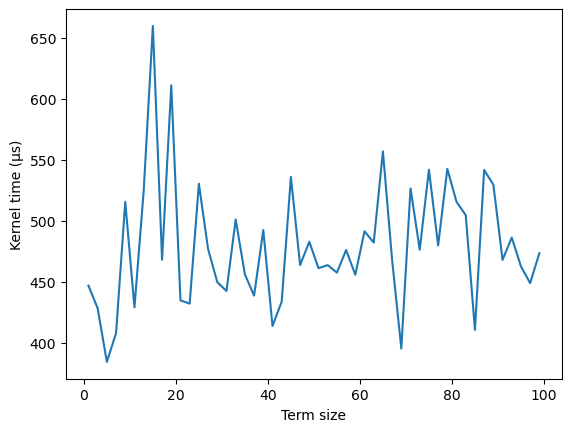

In [71]:
xs = [ ob.sz for ob in data.values() ]
ys = [ ob.t_kernel / NS_PER_US for ob in data.values() ]
(xs, ys) = zip(*sorted(zip(xs, ys)))

plt.xlabel("Term size")
plt.ylabel("Kernel time (µs)")
plt.plot(xs, ys)

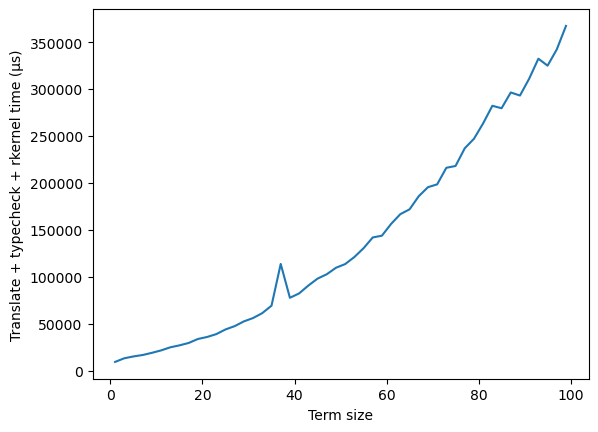

In [72]:
xs = [ ob.sz for ob in data.values() ]
ys = [ (ob.t_translate + ob.t_typecheck + ob.t_rkernel) / NS_PER_US for ob in data.values() ]
(xs, ys) = zip(*sorted(zip(xs, ys)))

plt.xlabel("Term size")
plt.ylabel("Translate + typecheck + rkernel time (µs)")
plt.plot(xs, ys)